In [7]:
import math

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import HTML

from matk.utils.animation import animate_frames

%matplotlib inline

In [63]:
import math

from typing import Tuple

import numpy as np

from matk.models.base_model import _BaseModel
from matk.utils.geometry import angle_between_points


def coord_to_from_point(position, distination, step_size, clipping, to=True):
    angle = angle_between_points(position, distination) 
    abs_angle = np.clip(abs(angle), 0, clipping)
    if angle < 0:
        angle = -abs_angle
    else:
        angle = abs_angle
    rad = math.radians(angle)
    dx = math.cos(rad) * step_size
    dy = math.sin(rad) * step_size
    if not to:
        dx = -dx
        dy = -dy
    else:
        if np.abs(position - distination).max() < 0.5:
            return 0, 0
        
    return dx, dy

class FlockingModel(_BaseModel):
    def __init__(
        self,
        n_points: int,
        field_size: Tuple[int, int],
        step_size: int,
        view: float = 5,
        minimum_separation: float = 20,
        max_align_turn: float = 30,
        max_cohere_turn: float = 20,
        max_separate_turn: float = 10
    ):
        super().__init__(
            n_points=n_points,
            field_size=field_size,
            step_size=step_size,
            keep_trajoctories=False,
        )
        self.view = view
        self.minimum_separation = minimum_separation
        self.max_align_turn = max_align_turn
        self.max_cohere_turn = max_cohere_turn
        self.max_separate_turn = max_separate_turn
        
        self.points = []
        self.is_placed = []
        self.flocks = []

    def create_field(self):
        point_coords = [
            np.random.randint(0, f_size, self.n_points)
            for f_size in self.field_size
        ]
        point_coords = np.stack(point_coords, axis=-1).astype(float)

        self.find_flocks(point_coords)
        self.points.append(point_coords)
        self.markup_field(point_coords)
        
    def compute_step_to_flockmate_heading(self, current_coord, coords):
        distances = np.linalg.norm( coords - current_coord[None, :], axis=-1)
        flock = coords[distances < self.view]
        if len(flock) < 2:
            return current_coord
        head = flock.mean(0)
        dx, dy = coord_to_from_point(
            current_coord, 
            head, 
            self.step_size,
            self.max_align_turn
        )
        current_coord[0] += dx
        current_coord[1] += dy
        return current_coord
    
    def compute_step_out_of_neighbour(self, current_coord, neighbour_coord):
        dx, dy = coord_to_from_point(
            current_coord, 
            neighbour_coord, 
            self.step_size, 
            self.max_separate_turn,
            to=False
        )
        current_coord[0] += dx
        current_coord[1] += dy
            
        return current_coord
    
    def compute_step_to_neighbour(self, current_coord, neighbour_coord):
        dx, dy = coord_to_from_point(
            current_coord, 
            neighbour_coord, 
            self.step_size, 
            self.max_cohere_turn
        )
        current_coord[0] += dx
        current_coord[1] += dy
            
        return current_coord
    
    def compute_dist_to_nearby(self, current_coord, current_coord_id, coords):
        all_p_exclude_current = np.delete(coords, current_coord_id, 0) 
        distances = np.linalg.norm( all_p_exclude_current - current_coord[None, :], axis=-1)
        argmin_dist = np.argmin(distances)
        nearest_point = all_p_exclude_current[argmin_dist]
        smallest_dist = distances[argmin_dist]
        return smallest_dist, nearest_point
    
    def find_flocks(self, coords):
        all_flocks = []
        
        for i in range(coords.shape[0]):
            point = coords[i]
            distances = np.linalg.norm( coords - point[None, :], axis=-1)
            flock_indices = np.where(distances < self.view)[0]
            if i == 0 or np.all([not np.array_equal(flock_indices, el) for el in all_flocks]):
                all_flocks.append(flock_indices)
            
        self.flocks.append(all_flocks)

    def step(self):
        current_coords = self.points[-1].copy()
        new_coords = np.zeros_like(current_coords)

        for i in range(current_coords.shape[0]):
            current_point = current_coords[i]
            smallest_dist, nearest_point = self.compute_dist_to_nearby(
                current_point,
                i,
                current_coords
            )
            if smallest_dist < self.minimum_separation:
                new_point = self.compute_step_out_of_neighbour(current_point, nearest_point)
                new_point = self.continious_boarder_mode(new_point)
            else:
                new_point = self.compute_step_to_flockmate_heading(current_point, current_coords)
                new_point = self.continious_boarder_mode(new_point)
                _, nearest_point = self.compute_dist_to_nearby(
                    new_point,
                    i,
                    current_coords
                )
                new_point = self.compute_step_to_neighbour(new_point, nearest_point)
                new_point = self.continious_boarder_mode(new_point)
                
            new_coords[i] = new_point
           
        self.find_flocks(new_coords)
        self.points.append(new_coords)
        self.markup_field(new_coords)

    def reset_partial(self):
        self.points = []
        self.stop = False


In [175]:
def subtract_headings(a, b):
    diff = a - b
    diff  = (diff + 180) % 360 - 180
    if diff == -180: return 180
    return diff

subtract_headings(180, 0)

180

In [228]:
import math

from typing import Tuple

import numpy as np

from matk.models.base_model import _BaseModel
from matk.utils.geometry import angle_between_points

class NetlogoFlockingModel(_BaseModel):
    def __init__(
        self,
        n_points: int,
        field_size: Tuple[int, int],
        step_size: int,
        view: float = 5,
        minimum_separation: float = 20,
        max_align_turn: float = 30,
        max_cohere_turn: float = 20,
        max_separate_turn: float = 10
    ):
        super().__init__(
            n_points=n_points,
            field_size=field_size,
            step_size=step_size,
            keep_trajoctories=False,
        )
        self.view = view
        self.minimum_separation = minimum_separation
        self.max_align_turn = max_align_turn
        self.max_cohere_turn = max_cohere_turn
        self.max_separate_turn = max_separate_turn
        
        self.points = []
        #self.flocks = []

    def create_field(self):
        point_coords = [
            np.random.randint(0, f_size, self.n_points)
            for f_size in self.field_size
        ]
        point_coords += [np.random.uniform(low=-180, high=180, size=self.n_points)]
        point_coords = np.stack(point_coords, axis=-1).astype(float)

        self.points.append(point_coords)
        self.markup_field(point_coords)
        
    def find_flockmates(self, point, point_id, coords):
        all_p_exclude_current = np.delete(coords, point_id, 0) 
        distances = np.linalg.norm( all_p_exclude_current[:,:-1] - point[None, :-1], axis=-1)
        return all_p_exclude_current[distances < self.view]  
    
    def find_nearest_neighbor(self, point, coords):
        distances = np.linalg.norm( coords - point[None, :], axis=-1)
        nearest_point = coords[np.argmin(distances)]
        distance = np.min(distances)
        return nearest_point, distance
    
    def avarage_flockmate_heading(self, flockmates, point):
        dx = np.cos(flockmates[:,-1]).sum()
        dy = np.sin(flockmates[:,-1]).sum()
        if dx == 0 and dy == 0:
            return point[-1]
        else:
            return math.atan2(dy ,dx)
    
    def turn_at_most(self, angle, max_angle):
        print(angle)
        if abs(angle) > max_angle:
            if angle > 0:
                return max_angle
            else:
                return - max_angle
        else:
            return angle
    
    def turn_away(self, coord, angle, max_angle):
        turn = self.turn_at_most(
            subtract_headings(coord[-1], angle), 
            max_angle
        )
        coord[-1] = coord[-1] + turn
        coord = self.rt(coord)
        
        return coord
    
    def turn_towards(self, coord, angle, max_angle):
        turn = self.turn_at_most(
            subtract_headings(angle, coord[-1]), 
            max_angle
        )
        coord[-1] = coord[-1] + turn
        coord = self.rt(coord)
        return coord
        
    def separate(self, point, separate_point):
        angle = separate_point[-1]
        current_coord = self.turn_away(point, angle, self.max_separate_turn)
            
        return current_coord
    
    def align(self, point, flockmates):
        avarage_flockmate_heading = self.avarage_flockmate_heading(flockmates, point)
        return self.turn_towards(
            point,
            avarage_flockmate_heading, 
            self.max_align_turn
        )
        
    def do_flock(self, point, point_id, coords):
        flockmates = self.find_flockmates(point, point_id, coords)
        if len(flockmates) > 0:
            nearest_neighbor, distance = self.find_nearest_neighbor(point, flockmates)
            if distance < self.minimum_separation:
                result_coord = self.separate(point, nearest_neighbor)
            else:
                result_coord = self.align(point, flockmates)
        else:
            result_coord = point#self.rt(point)
                
        return result_coord
                
    def rt(self, coord):
        angle = coord[-1]
        
        rad = math.radians(angle)
        
        dx = math.cos(rad) * self.step_size
        dy = math.sin(rad) * self.step_size
        
        coord[0] += dx
        coord[1] += dy
        
        coord = self.continious_boarder_mode(coord)
        
        return coord
    

    def step(self):
        current_coords = self.points[-1].copy()
        new_coords = np.zeros_like(current_coords)

        for i in range(current_coords.shape[0]):
            new_coords[i] = self.do_flock(current_coords[i], i, current_coords)
           
        self.points.append(new_coords)
        self.markup_field(new_coords)

    def reset_partial(self):
        self.points = []
        self.stop = False


In [125]:
math.atan2()

0.4636476090008061

In [114]:
math.sin(math.radians(angle_between_points(
    np.array([0,1]), 
    np.array([-1,0])
)))

-0.7071067811865476

In [229]:
model = NetlogoFlockingModel(
    100, 
    (64, 64), 
    1,
    view=30,
    minimum_separation=2,
    max_align_turn=2,
    max_cohere_turn=2,
    max_separate_turn=2
)

In [214]:
angles = np.stack([p[:,-1] for p in model.points])

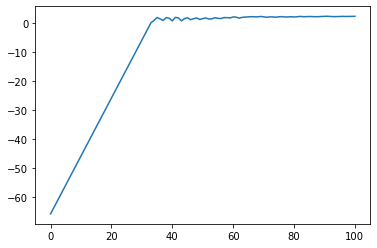

In [224]:
plt.plot(angles[:,6])

In [230]:
model.run_n_steps(100)

  7%|▋         | 7/100 [00:00<00:01, 68.98it/s]

-32.824454383300804
-23.82439831963967
-95.9636386156398
-82.62079296925596
-112.57007603805162
54.254529311407765
-90.66567911689322
-167.52034804229402
-37.07542768442764
-83.5369388626625
27.085942184935732
-179.75665236583563
-29.11450642479039
-60.755381651333465
-67.20525869499886
157.5915900380934
110.42526486123944
174.17566553183792
-131.36942258878375
87.92619708338623
-136.405922167932
-171.20898848632794
75.23446097573844
9.723574544931637
-56.9319180058701
-136.74957087401867
-117.82964730038961
41.36738562476259
156.61903953057686
-10.20656004047919
3.4112730423384505
88.84214721261486
-66.16846384717523
110.6837927460777
160.36498437252715
-164.3245175470916
111.66258034171159
56.62087510612224
-46.3602418031719
58.36132245668682
-32.9649108220797
5.945708436218581
167.27413546786045
155.11051090195758
-163.2894961749684
41.995124046492094
156.68361209089278
-49.82031459843304
169.7998925152457
23.445850754260704
-123.81085776356333
-52.148105813288026
24.160244172327452

 21%|██        | 21/100 [00:00<00:01, 69.22it/s]


7.665026198331418
39.2810125504098
-8.904861708496014
-1.3164234426846804
-66.14962205879227
-56.315606859382314
-87.63901979613586
24.430362574615856
-60.82160246218348
-143.45053043239392
-10.390934805575569
-57.33476795246014
-1.193716143740744
154.11181813952066
-4.456331041394236
-36.733365959957496
-42.09558944209533
131.81591156655486
80.27933381016658
143.03891141814233
-102.282472635883
58.755064437308135
-111.35272834318394
-145.06589302847823
48.78068883975308
-1.2728460595805018
-29.907979260199824
-107.94439678072162
-88.5399643992414
13.712731320669207
129.88949207658578
-0.6514432631465468
-0.7169394016034119
59.18172370027892
-39.133795775628215
84.28875166412661
130.91952349382427
-138.65603224965858
82.06790895408096
29.956312255243006
-18.9004949393221
29.45200984267376
-4.198350680230533
-0.4152637882708916
138.04219243156922
124.39737531131198
-136.4064571864555
13.938042115423855
130.31337706614352
-21.995427158120123
140.3894061466052
-3.096861112909295
-101.188

 37%|███▋      | 37/100 [00:00<00:00, 70.03it/s]


-0.35824934540920594
-30.059457347269273
0.3883476842638345
126.37353060521326
-0.34914587601531366
-8.28788701444239
-14.55299429219906
103.33899313751249
51.85548293586268
115.13779589943988
-73.26750696159387
31.05665880862901
-83.25558616899238
-118.25365273811823
20.4305238848722
0.2699285027615872
-1.8165465382569437
-79.49346615910392
-59.957733623116596
-0.1545005097579235
101.67982794894078
1.0308992147617175
-1.540357300751566
31.457355220114522
-10.71505058795438
57.647135684861325
103.44001808049973
-110.16398669097146
54.939686780723235
3.2625967096013824
0.02323094343108778
2.7486800445117296
0.3905468979700686
0.5057202475126701
111.05419226770607
97.11975205647428
-108.29959386993731
-1.0260396227738795
102.32763748760749
0.30372727571005953
112.8328416037981
1.1060505122875668
-70.79979978519661
0.5545967360580448
0.1387286228441269
-14.234304987914754
-106.4764723414198
0.38375191090347016
-79.79966689905578
83.52539722002734
0.12400641582286198
67.90318721620079
56.

 53%|█████▎    | 53/100 [00:00<00:00, 71.86it/s]

55.278056907105
0.2892836158490013
39.8837591102787
28.591654001163192
-90.3408868010407
-79.36104143294085
3.356430751755937
63.08266702979583
51.162769254698986
35.002304638388125
-13.01523033929007
-0.2285337678107453
-0.37192119555024306
-0.1010616785356433
-0.24343111948482488
0.14201209553581862
0.17524323583140244
-0.5951539107111614
-0.44153521896021175
-0.48411753315610895
-0.5339678519197548
-0.15311137066322544
69.59206212958503
0.8481931424396407
-0.3931038030995637
0.12741031123383095
-0.23756362607605297
-0.1504431607065726
0.4016715580351047
0.11621105328052295
-42.40321233454338
6.32126966073929
-0.358959193551982
-37.307041534264016
-59.82175812885092
-51.52981289375214
-0.19216802611924777
0.005973632474081114
2.3399416513261144
0.005950812267087713
-0.16145916263502613
-0.2589308726897457
0.12481827642042731
0.08126343672861935
0.002679274594385106
-7.531075491099557
-0.3164226863488864
-28.97850916147985
0.16566513249875925
-2.246758050665534
-85.41972491135424
-0.1

 67%|██████▋   | 67/100 [00:00<00:00, 69.42it/s]

57.358095076915674
-15.184811155581684
-0.3500767455473124
-24.93991996687933
-59.478396646109644
0.18524258062362264
0.1369769346760279
0.20482283196218987
-21.363084843647613
-1.8250155172352436
0.11812454083363377
43.849458422357884
-0.025370524017148455
0.4775417547816403
0.12507907428084764
-0.09486435065534238
0.0566110040421961
45.27086726007491
-52.33850043300566
-0.4044657470114146
-0.32449502826204935
0.09767665618650767
0.2660375169073177
0.2435047344269492
0.27044293670255115
53.43855568570629
38.96005193531363
-50.122897663587935
-0.966828653621775
44.73039050784337
0.3147848011025758
55.32883683478667
-0.12331476158087185
-13.390574937406654
0.025198261892597884
0.08924762173228373
-0.07752487086145265
-48.48053632001785
0.018456043371571695
-21.321564512535303
25.38327614939604
-0.03320591494801306
9.868322390879143
0.1468575355261521
-60.21447093165909
-49.35626786738618
0.36486676203705315
33.34007561350364
21.260765945430478
5.016332054537372
0.036001401328491056
-0.3

 83%|████████▎ | 83/100 [00:01<00:00, 71.64it/s]

0.06135298844347403
0.1769088193719881
0.5431442136006126
0.09213219044653442
0.21512328499309774
-28.6680076521327
0.49039487692303396
0.4920555292946176
0.08718582749028769
40.67938013255241
0.10222591834462946
0.2383753427169779
0.40518366012793194
18.19796663147048
0.3997950212814203
30.17505871534368
-0.15409731503243052
0.29463371847324993
-2.088895305698003
-31.13207860429273
0.1413005708758419
0.1842768461672506
0.13309295056248516
0.11372667005923631
0.08871145555340831
0.24080282784737506
16.521264333771086
0.23714468300701697
-1.2592605822876806
0.23838651928329568
0.11777309423825955
0.08081328370209917
17.64636907559344
-24.12967641912263
0.23298289535568983
0.22816044804977764
0.1807739423547048
0.14225528537053833
0.15481907249684923
0.16665756481839367
25.831017406827442
11.372344217406237
-21.80556664400234
-0.14591683046373305
17.1755995095468
-1.4591731491615292
27.688523090070817
0.16682449083540973
0.05715739427532185
0.13944347002700397
0.10585510399633336
0.11268

100%|██████████| 100/100 [00:01<00:00, 71.60it/s]

-0.06992387773541964
-0.0680118103112477
-0.09520379569900683
0.014791464974678092
-0.07146015902631575
-0.11590919394078014
0.027161889665194394
-0.003706365171382231
-2.194540415920443
-0.08936180640415614
-0.06791896069029235
0.01438083739861895
10.479564734280729
0.019657576493102624
-0.012898732070851793
-0.10706919463959252
-0.06742097727607188
-0.12060004718955497
-0.04115699125947003
-0.508548934399812
-0.11325872317272001
1.8347577606048162
-1.4845388379345081
-0.11373888306582103
-1.1115442609175261
-0.018879789184410356
-0.013095864763357667
-0.05391741822234053
-0.06994151466994936
-0.039592053518674675
-0.10008499643575419
-0.1732804380737889
-0.057173956218434796
-0.030847454129229845
-0.25433922530839936
-0.056465006348332736
-0.2640270829451197
-0.08560509379657333
-0.06219890764376146
-0.0516882596578796
-0.04645708176596486
-0.04742814533975093
-0.041764298621956186
-0.04399140369011434
-1.0042329426484002
-0.07120596928140799
0.3465608761475778
-0.0681114345751439
1.

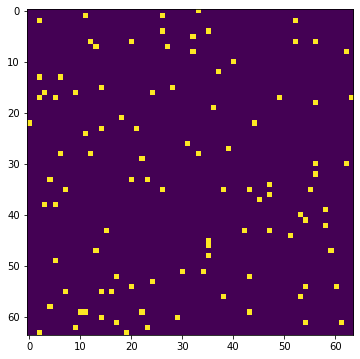

In [207]:
ani = animate_frames(model, figsize=(6,6), interval=100)
HTML(ani.to_jshtml())